# MIMIC-IV ED ICD-Codes Exploration

Dieses Notebook exploriert alle ICD-Codes im `mimiciv_ed` Schema der MIMIC-IV Datenbank.

In [2]:
# Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Datenbankverbindung herstellen

In [3]:
# Datenbank-Verbindungsparameter
sqluser = 'anja'
sqlpass = 'postgres'  # Bitte anpassen
dbname = 'mimiciv'      # Bitte anpassen
schema_name = 'mimiciv_ed'
host = 'localhost'

# Verbindung zur Datenbank herstellen
try:
    con = psycopg2.connect(
        dbname=dbname, 
        user=sqluser, 
        password=sqlpass, 
        host=host
    )
    print("✓ Erfolgreich mit der Datenbank verbunden")
except Exception as e:
    print(f"✗ Fehler bei der Verbindung: {e}")
    raise

✓ Erfolgreich mit der Datenbank verbunden


## Schema und Tabellen erkunden

In [8]:
# Alle Tabellen im mimiciv_ed Schema anzeigen
query = """
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'mimiciv_ed'
ORDER BY table_name;
"""

tables = pd.read_sql_query(query, con)
print(f"Anzahl Tabellen im Schema mimiciv_ed: {len(tables)}")
print("\nTabellen:")
display(tables)

Anzahl Tabellen im Schema mimiciv_ed: 6

Tabellen:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/951224422.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql_query(query, con)


,table_name
0,diagnosis
1,edstays
2,medrecon
3,pyxis
4,triage
5,vitalsign


## ICD-Code Tabelle identifizieren und laden

In [9]:
# Nach Tabellen suchen, die ICD-Codes enthalten könnten
query = """
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'mimiciv_ed'
  AND (column_name LIKE '%icd%' OR column_name LIKE '%diag%')
ORDER BY table_name, ordinal_position;
"""

icd_columns = pd.read_sql_query(query, con)
print("Tabellen mit ICD/Diagnose-Spalten:")
display(icd_columns)

Tabellen mit ICD/Diagnose-Spalten:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/23738527.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  icd_columns = pd.read_sql_query(query, con)


,table_name,column_name,data_type
0,diagnosis,icd_code,character varying
1,diagnosis,icd_version,smallint
2,diagnosis,icd_title,text


## Diagnose-Daten laden (falls vorhanden)

In [10]:
# Versuche, die Diagnose-Tabelle zu laden
query = """
SELECT * 
FROM mimiciv_ed.diagnosis
LIMIT 10;
"""

try:
    diagnosis_sample = pd.read_sql_query(query, con)
    print("Erste 10 Zeilen der Diagnose-Tabelle:")
    display(diagnosis_sample)
except Exception as e:
    print(f"Fehler beim Laden der Diagnose-Tabelle: {e}")
    print("\nVersuche alternative Tabellennamen...")

Erste 10 Zeilen der Diagnose-Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/2432753289.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diagnosis_sample = pd.read_sql_query(query, con)


,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,10000032,32952584,1,4589,9,HYPOTENSION NOS
1,10000032,32952584,2,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS"
4,10000032,33258284,2,78959,9,OTHER ASCITES
5,10000032,33258284,3,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
6,10000032,33258284,4,V08,9,ASYMPTOMATIC HIV INFECTION
7,10000032,35968195,1,5715,9,CIRRHOSIS OF LIVER NOS
8,10000032,35968195,2,78900,9,ABDOMINAL PAIN UNSPEC SITE
9,10000032,35968195,3,V08,9,ASYMPTOMATIC HIV INFECTION


In [11]:
# Struktur der Diagnose-Tabelle anzeigen
query = """
SELECT column_name, data_type, character_maximum_length
FROM information_schema.columns
WHERE table_schema = 'mimiciv_ed' 
  AND table_name = 'diagnosis'
ORDER BY ordinal_position;
"""

try:
    diagnosis_structure = pd.read_sql_query(query, con)
    print("Struktur der Diagnose-Tabelle:")
    display(diagnosis_structure)
except Exception as e:
    print(f"Fehler: {e}")

Struktur der Diagnose-Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/3556715379.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diagnosis_structure = pd.read_sql_query(query, con)


,column_name,data_type,character_maximum_length
0,subject_id,integer,NaN
1,stay_id,integer,NaN
2,seq_num,integer,NaN
3,icd_code,character varying,8.0
4,icd_version,smallint,NaN
5,icd_title,text,NaN


## Alle ICD-Codes laden und analysieren

In [12]:
# Alle ICD-Codes aus der Diagnose-Tabelle laden
query = """
SELECT 
    icd_code,
    icd_version,
    icd_title,
    COUNT(*) as anzahl_diagnosen
FROM mimiciv_ed.diagnosis
GROUP BY icd_code, icd_version, icd_title
ORDER BY anzahl_diagnosen DESC;
"""

try:
    icd_codes = pd.read_sql_query(query, con)
    print(f"Gesamtanzahl einzigartiger ICD-Codes: {len(icd_codes)}")
    print(f"\nTop 20 häufigste ICD-Codes:")
    display(icd_codes.head(20))
except Exception as e:
    print(f"Fehler: {e}")
    print("\nPasse die Query basierend auf der tatsächlichen Tabellenstruktur an.")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/630525440.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  icd_codes = pd.read_sql_query(query, con)


Gesamtanzahl einzigartiger ICD-Codes: 13214

Top 20 häufigste ICD-Codes:


,icd_code,icd_version,icd_title,anzahl_diagnosen
0,4019,9,HYPERTENSION NOS,26816
1,I10,10,Essential (primary) hypertension,21264
2,R079,10,"Chest pain, unspecified",13016
3,78650,9,CHEST PAIN NOS,12398
4,25000,9,DIABETES UNCOMPL ADULT,12026
5,R109,10,Unspecified abdominal pain,10504
6,E119,10,Type 2 diabetes mellitus without complications,8801
7,78909,9,ABDOMINAL PAIN OTHER SPECIED,8704
8,W1830XA,10,"Fall on same level, unspecified, initial encou...",7817
9,E8889,9,UNSPECIFIED FALL,7081


In [22]:
# Save results to CSV but only unique ICD codes (based on code + version)
icd_codes_unique = icd_codes.drop_duplicates(subset=['icd_code', 'icd_version'])
icd_codes_unique[['icd_code', 'icd_version', 'icd_title']].to_csv('mimiciv_ed_icd_codes.csv', index=False)

## Statistiken zu ICD-Versionen

In [ ]:
# ICD-Versionen analysieren
query = """
SELECT 
    icd_version,
    COUNT(DISTINCT icd_code) as anzahl_einzigartige_codes,
    COUNT(*) as gesamtanzahl_diagnosen
FROM mimiciv_ed.diagnosis
GROUP BY icd_version
ORDER BY icd_version;
"""

try:
    icd_versions = pd.read_sql_query(query, con)
    print("ICD-Versionen im Dataset:")
    display(icd_versions)
    
    # Visualisierung
    if not icd_versions.empty:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Balkendiagramm für einzigartige Codes
        ax1.bar(icd_versions['icd_version'].astype(str), 
                icd_versions['anzahl_einzigartige_codes'])
        ax1.set_title('Anzahl einzigartiger ICD-Codes pro Version')
        ax1.set_xlabel('ICD Version')
        ax1.set_ylabel('Anzahl Codes')
        
        # Balkendiagramm für Gesamtdiagnosen
        ax2.bar(icd_versions['icd_version'].astype(str), 
                icd_versions['gesamtanzahl_diagnosen'])
        ax2.set_title('Gesamtanzahl Diagnosen pro ICD-Version')
        ax2.set_xlabel('ICD Version')
        ax2.set_ylabel('Anzahl Diagnosen')
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Fehler: {e}")

## ICD-Codes nach Kategorie

In [ ]:
# ICD-9 Codes: Erste 3 Zeichen als Kategorie
# ICD-10 Codes: Erster Buchstabe oder erste 3 Zeichen als Kategorie
query = """
SELECT 
    icd_version,
    CASE 
        WHEN icd_version = 9 THEN SUBSTRING(icd_code, 1, 3)
        WHEN icd_version = 10 THEN SUBSTRING(icd_code, 1, 1)
    END as kategorie,
    COUNT(*) as anzahl
FROM mimiciv_ed.diagnosis
GROUP BY icd_version, kategorie
ORDER BY icd_version, anzahl DESC;
"""

try:
    icd_categories = pd.read_sql_query(query, con)
    print("\nTop ICD-Kategorien:")
    display(icd_categories.head(20))
except Exception as e:
    print(f"Fehler: {e}")

## Top 30 häufigste Diagnosen visualisieren

In [ ]:
# Top 30 Diagnosen visualisieren
try:
    top_30 = icd_codes.head(30).copy()
    
    # Abkürzung für lange Titel
    top_30['kurztitel'] = top_30['icd_title'].str[:50] + '...'
    top_30['label'] = top_30['icd_code'] + ': ' + top_30['kurztitel']
    
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(top_30)), top_30['anzahl_diagnosen'])
    plt.yticks(range(len(top_30)), top_30['label'], fontsize=8)
    plt.xlabel('Anzahl Diagnosen')
    plt.title('Top 30 häufigste ICD-Diagnosen im ED')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Fehler bei der Visualisierung: {e}")

## Detailansicht: Alle ICD-Codes exportieren

In [ ]:
# Alle ICD-Codes anzeigen (scrollbar)
print(f"Vollständige Liste aller {len(icd_codes)} ICD-Codes:")
display(icd_codes)

In [ ]:
# Optional: Als CSV exportieren
# icd_codes.to_csv('mimiciv_ed_icd_codes.csv', index=False)
# print("ICD-Codes wurden als 'mimiciv_ed_icd_codes.csv' exportiert")

## Suche nach bestimmten ICD-Codes

In [ ]:
# Suche nach Stichwort in ICD-Titel (z.B. "pneumonia", "sepsis", "fracture")
suchwort = "chest"  # Hier kannst du ein beliebiges Stichwort eingeben

ergebnis = icd_codes[icd_codes['icd_title'].str.contains(suchwort, case=False, na=False)]
print(f"\nGefunden: {len(ergebnis)} ICD-Codes mit '{suchwort}':")
display(ergebnis)

## Chief Complaints (Leitsymptome) extrahieren

In [29]:
# anzahl aller zeilen in der Triage tabelle
query = """
SELECT COUNT(*) as anzahl_zeilen
FROM mimiciv_ed.triage;
"""
anzahl_zeilen = pd.read_sql_query(query, con)
print("Anzahl der Zeilen in der Triage-Tabelle:", anzahl_zeilen['anzahl_zeilen'][0])

Anzahl der Zeilen in der Triage-Tabelle: 425087


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/1823385858.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  anzahl_zeilen = pd.read_sql_query(query, con)


In [30]:
# Struktur der Triage-Tabelle anzeigen
query = """
SELECT column_name, data_type, character_maximum_length
FROM information_schema.columns
WHERE table_schema = 'mimiciv_ed'
  AND table_name = 'triage'
ORDER BY ordinal_position;
"""

try:
    triage_structure = pd.read_sql_query(query, con)
    print("Struktur der Triage-Tabelle:")
    display(triage_structure)
except Exception as e:
    print(f"Fehler: {e}")

Struktur der Triage-Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/4178699691.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  triage_structure = pd.read_sql_query(query, con)


,column_name,data_type,character_maximum_length
0,subject_id,integer,NaN
1,stay_id,integer,NaN
2,temperature,numeric,NaN
3,heartrate,numeric,NaN
4,resprate,numeric,NaN
5,o2sat,numeric,NaN
6,sbp,numeric,NaN
7,dbp,numeric,NaN
8,pain,text,NaN
9,acuity,numeric,NaN


In [31]:
# Erste Einträge der Triage-Tabelle anschauen
query = """
SELECT *
FROM mimiciv_ed.triage
LIMIT 10;
"""

try:
    triage_sample = pd.read_sql_query(query, con)
    print("\nErste 10 Zeilen der Triage-Tabelle:")
    display(triage_sample)
except Exception as e:
    print(f"Fehler: {e}")


Erste 10 Zeilen der Triage-Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/1856213361.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  triage_sample = pd.read_sql_query(query, con)


,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.80,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.40,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.40,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.90,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.70,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"
5,10000084,35203156,97.50,78.0,16.0,100.0,114.0,71.0,0,2.0,"Confusion, Hallucinations"
6,10000084,36954971,98.70,80.0,16.0,95.0,111.0,72.0,0,2.0,"Altered mental status, B Pedal edema"
7,10000108,32522732,98.21,83.0,20.0,100.0,112.0,81.0,5,3.0,L CHEEK ABSCESS
8,10000108,36533795,98.80,98.0,16.0,100.0,135.0,85.0,5,3.0,"LEFT CHEEK SWELLING, Abscess"
9,10000108,39513268,98.80,101.0,18.0,100.0,131.0,62.0,5,3.0,L FACIAL SWELLING


### Alle Chief Complaints analysieren

In [32]:
# Alle Chief Complaints extrahieren und zählen
query = """
SELECT
    chiefcomplaint,
    COUNT(*) as anzahl
FROM mimiciv_ed.triage
WHERE chiefcomplaint IS NOT NULL
  AND chiefcomplaint != ''
GROUP BY chiefcomplaint
ORDER BY anzahl DESC;
"""

try:
    chief_complaints = pd.read_sql_query(query, con)
    print(f"Gesamtanzahl verschiedener Chief Complaints: {len(chief_complaints)}")
    print(f"\nTop 30 häufigste Chief Complaints:")
    display(chief_complaints.head(30))
except Exception as e:
    print(f"Fehler: {e}")

Gesamtanzahl verschiedener Chief Complaints: 60407

Top 30 häufigste Chief Complaints:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/1816049282.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chief_complaints = pd.read_sql_query(query, con)


,chiefcomplaint,anzahl
0,Chest pain,11301
1,Abd pain,10771
2,Dyspnea,6003
3,s/p Fall,4965
4,ABD PAIN,4957
5,SI,4926
6,ETOH,4679
7,Wound eval,4509
8,Headache,3828
9,Back pain,3166


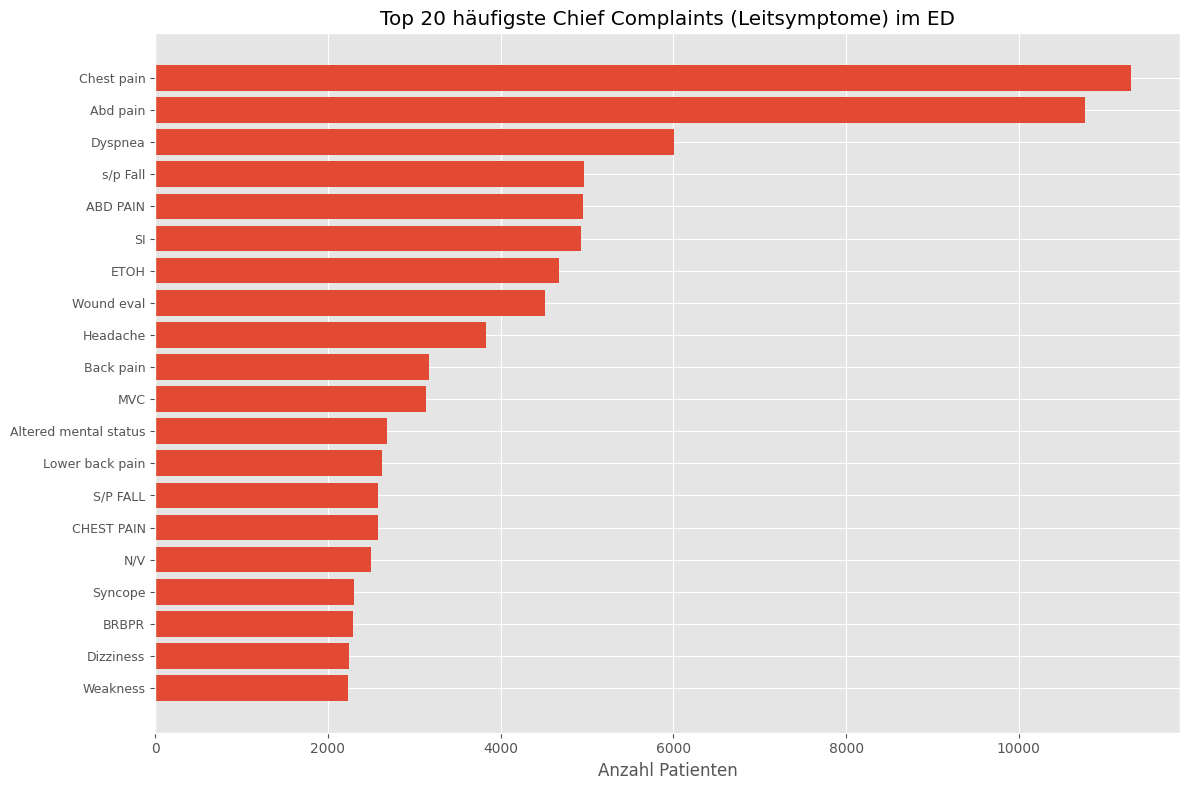

In [27]:
# Top 20 Chief Complaints visualisieren
try:
    if not chief_complaints.empty:
        top_20_cc = chief_complaints.head(20).copy()
        
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_20_cc)), top_20_cc['anzahl'])
        plt.yticks(range(len(top_20_cc)), top_20_cc['chiefcomplaint'], fontsize=9)
        plt.xlabel('Anzahl Patienten')
        plt.title('Top 20 häufigste Chief Complaints (Leitsymptome) im ED')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Fehler bei der Visualisierung: {e}")

### Chief Complaints nach Kategorien gruppieren


Chief Complaints nach Kategorien:


kategorie
Schmerz             164807
Sonstige            146103
Neurologie           32202
Trauma               31200
Atem/Lunge           25508
Fieber/Infektion      8799
Gastrointestinal      6952
Psychiatrisch         4944
Herz                  4550
Name: anzahl, dtype: int64

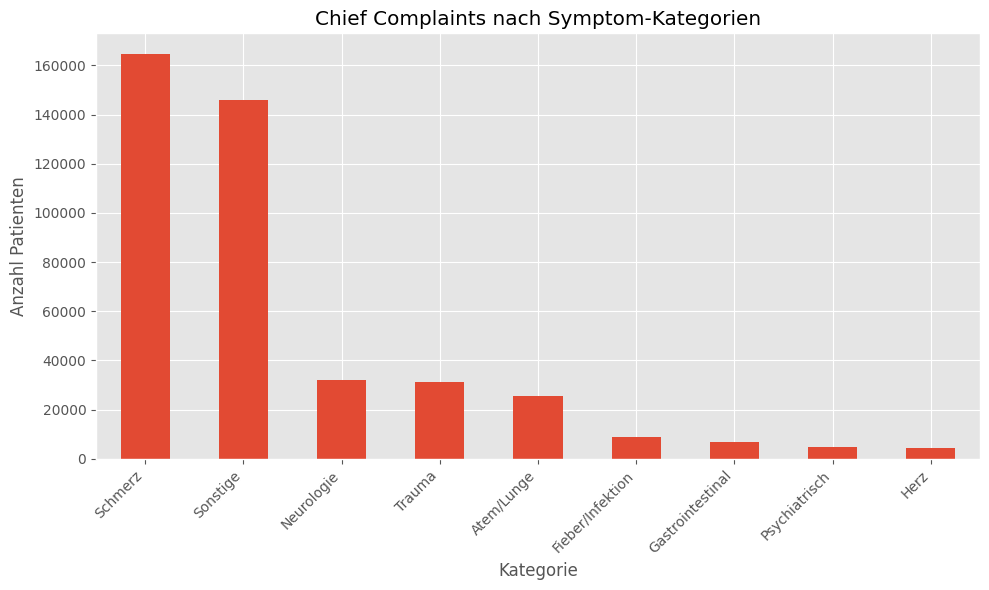

In [28]:
# Häufige Symptom-Kategorien identifizieren
kategorien = {
    'Schmerz': ['pain', 'ache'],
    'Atem/Lunge': ['breath', 'dyspnea', 'cough', 'respiratory', 'sob'],
    'Herz': ['chest', 'cardiac', 'heart', 'palpitation'],
    'Neurologie': ['headache', 'dizziness', 'syncope', 'seizure', 'weakness', 'altered mental'],
    'Trauma': ['fall', 'injury', 'trauma', 'laceration', 'fracture'],
    'Gastrointestinal': ['abdominal', 'nausea', 'vomiting', 'diarrhea'],
    'Fieber/Infektion': ['fever', 'infection', 'sepsis'],
    'Psychiatrisch': ['psychiatric', 'suicidal', 'anxiety', 'depression']
}

# Complaints kategorisieren
def kategorisiere_complaint(complaint):
    if pd.isna(complaint):
        return 'Unbekannt'
    complaint_lower = complaint.lower()
    for kategorie, keywords in kategorien.items():
        for keyword in keywords:
            if keyword in complaint_lower:
                return kategorie
    return 'Sonstige'

try:
    chief_complaints['kategorie'] = chief_complaints['chiefcomplaint'].apply(kategorisiere_complaint)
    
    # Nach Kategorien zusammenfassen
    kategorie_stats = chief_complaints.groupby('kategorie')['anzahl'].sum().sort_values(ascending=False)
    
    print("\nChief Complaints nach Kategorien:")
    display(kategorie_stats)
    
    # Visualisierung
    plt.figure(figsize=(10, 6))
    kategorie_stats.plot(kind='bar')
    plt.title('Chief Complaints nach Symptom-Kategorien')
    plt.xlabel('Kategorie')
    plt.ylabel('Anzahl Patienten')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Fehler: {e}")

In [ ]:
# Chief Complaints als CSV exportieren
try:
    chief_complaints[['chiefcomplaint', 'anzahl', 'kategorie']].to_csv('mimiciv_ed_chief_complaints.csv', index=False)
    print("Chief Complaints wurden als 'mimiciv_ed_chief_complaints.csv' exportiert")
except Exception as e:
    print(f"Fehler beim Export: {e}")

### Zusammenhang zwischen Chief Complaints und ICD-Codes

In [ ]:
# Chief Complaints mit Diagnosen verknüpfen
query = """
SELECT
    t.chiefcomplaint,
    d.icd_code,
    d.icd_version,
    d.icd_title,
    COUNT(*) as anzahl
FROM mimiciv_ed.triage t
JOIN mimiciv_ed.diagnosis d ON t.stay_id = d.stay_id
WHERE t.chiefcomplaint IS NOT NULL
  AND t.chiefcomplaint != ''
GROUP BY t.chiefcomplaint, d.icd_code, d.icd_version, d.icd_title
ORDER BY anzahl DESC
LIMIT 50;
"""

try:
    cc_diagnosis = pd.read_sql_query(query, con)
    print("Top 50 Kombinationen von Chief Complaint und Diagnose:")
    display(cc_diagnosis)
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/1463974031.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cc_diagnosis = pd.read_sql_query(query, con)


Top 50 Kombinationen von Chief Complaint und Diagnose:


,chiefcomplaint,icd_code,icd_version,icd_title,anzahl
0,Chest pain,R079,10,"Chest pain, unspecified",4519
1,Chest pain,78650,9,CHEST PAIN NOS,2898
2,SI,R45851,10,Suicidal ideations,2346
3,Abd pain,R109,10,Unspecified abdominal pain,2193
4,ETOH,F10129,10,"Alcohol abuse with intoxication, unspecified",2053
5,SI,F329,10,"Major depressive disorder, single episode, uns...",1958
6,CHEST PAIN,78650,9,CHEST PAIN NOS,1818
7,Headache,R51,10,Headache,1815
8,Dyspnea,R0600,10,"Dyspnea, unspecified",1800
9,ETOH,30500,9,ALCOHOL ABUSE-UNSPEC,1676


In [ ]:
# Beispiel: Alle Diagnosen für "Chest Pain" Chief Complaint
beispiel_complaint = 'CHEST PAIN'

query = f"""
SELECT
    d.icd_code,
    d.icd_version,
    d.icd_title,
    COUNT(*) as anzahl
FROM mimiciv_ed.triage t
JOIN mimiciv_ed.diagnosis d ON t.stay_id = d.stay_id
WHERE t.chiefcomplaint = '{beispiel_complaint}'
GROUP BY d.icd_code, d.icd_version, d.icd_title
ORDER BY anzahl DESC
LIMIT 20;
"""

try:
    cc_example = pd.read_sql_query(query, con)
    print(f"\nTop 20 Diagnosen bei Chief Complaint '{beispiel_complaint}':")
    display(cc_example)
except Exception as e:
    print(f"Fehler: {e}")

In [35]:
# Detaillierte Übersicht mit allen Informationen
query = """
SELECT
    t.subject_id,
    t.stay_id,
    t.chiefcomplaint,
    d.seq_num,
    d.icd_code,
    d.icd_version,
    d.icd_title
FROM mimiciv_ed.triage t
JOIN mimiciv_ed.diagnosis d ON t.stay_id = d.stay_id
WHERE t.chiefcomplaint IS NOT NULL
  AND t.chiefcomplaint != ''
ORDER BY t.subject_id, t.stay_id, d.seq_num;
"""

try:
    detailed_data = pd.read_sql_query(query, con)
    print(f"Gesamtanzahl Datensätze: {len(detailed_data)}")
    print(f"Anzahl einzigartige Patienten: {detailed_data['subject_id'].nunique()}")
    print(f"Anzahl einzigartige ED-Aufenthalte: {detailed_data['stay_id'].nunique()}")
    print("\nErste 20 Zeilen:")
    display(detailed_data.head(20))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_98006/2497767621.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_data = pd.read_sql_query(query, con)


Gesamtanzahl Datensätze: 899021
Anzahl einzigartige Patienten: 205121
Anzahl einzigartige ED-Aufenthalte: 423967

Erste 20 Zeilen:


,subject_id,stay_id,chiefcomplaint,seq_num,icd_code,icd_version,icd_title
0,10000032,32952584,Hypotension,1,4589,9,HYPOTENSION NOS
1,10000032,32952584,Hypotension,2,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
2,10000032,32952584,Hypotension,3,V08,9,ASYMPTOMATIC HIV INFECTION
3,10000032,33258284,"Abd pain, Abdominal distention",1,5728,9,"OTH SEQUELA, CHR LIV DIS"
4,10000032,33258284,"Abd pain, Abdominal distention",2,78959,9,OTHER ASCITES
5,10000032,33258284,"Abd pain, Abdominal distention",3,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...
6,10000032,33258284,"Abd pain, Abdominal distention",4,V08,9,ASYMPTOMATIC HIV INFECTION
7,10000032,35968195,"n/v/d, Abd pain",1,5715,9,CIRRHOSIS OF LIVER NOS
8,10000032,35968195,"n/v/d, Abd pain",2,78900,9,ABDOMINAL PAIN UNSPEC SITE
9,10000032,35968195,"n/v/d, Abd pain",3,V08,9,ASYMPTOMATIC HIV INFECTION


In [40]:
only_chiefcomplaints = chief_complaints[['chiefcomplaint']].drop_duplicates().reset_index(drop=True)
only_chiefcomplaints

# check if there are any empty chief complaints or duplicates
empty_cc = only_chiefcomplaints[only_chiefcomplaints['chiefcomplaint'].isnull() | (only_chiefcomplaints['chiefcomplaint'] == '')]
print(f"Anzahl leerer Chief Complaints: {len(empty_cc)}")
duplicates_cc = only_chiefcomplaints[only_chiefcomplaints.duplicated(subset=['chiefcomplaint'], keep=False)]
print(f"Anzahl doppelter Chief Complaints: {len(duplicates_cc)}")
duplicates_cc

# save chief complaints to csv
only_chiefcomplaints.to_csv('mimiciv_ed_chief_complaints.csv', index=False)
print("Chief Complaints wurden als 'mimiciv_ed_only_chief_complaints.csv' exportiert")

Anzahl leerer Chief Complaints: 0
Anzahl doppelter Chief Complaints: 0
Chief Complaints wurden als 'mimiciv_ed_only_chief_complaints.csv' exportiert


In [36]:
# Als CSV exportieren
try:
    detailed_data.to_csv('mimiciv_ed_detailed_cc_icd.csv', index=False)
    print("✓ Detaillierte Daten wurden als 'mimiciv_ed_detailed_cc_icd.csv' exportiert")
    print(f"  - {len(detailed_data)} Zeilen")
    print(f"  - {detailed_data['subject_id'].nunique()} einzigartige Patienten")
    print(f"  - {detailed_data['stay_id'].nunique()} einzigartige ED-Aufenthalte")
except Exception as e:
    print(f"Fehler beim Export: {e}")

✓ Detaillierte Daten wurden als 'mimiciv_ed_detailed_cc_icd.csv' exportiert
  - 899021 Zeilen
  - 205121 einzigartige Patienten
  - 423967 einzigartige ED-Aufenthalte


In [ ]:
# Beispielanalyse: Wie viele ICD-Codes hat ein Patient typischerweise?
try:
    icd_per_stay = detailed_data.groupby('stay_id').size().reset_index(name='anzahl_icd_codes')
    
    print("\nStatistik: Anzahl ICD-Codes pro ED-Aufenthalt:")
    print(f"  Durchschnitt: {icd_per_stay['anzahl_icd_codes'].mean():.2f}")
    print(f"  Median: {icd_per_stay['anzahl_icd_codes'].median():.0f}")
    print(f"  Minimum: {icd_per_stay['anzahl_icd_codes'].min()}")
    print(f"  Maximum: {icd_per_stay['anzahl_icd_codes'].max()}")
    
    # Visualisierung
    plt.figure(figsize=(10, 6))
    plt.hist(icd_per_stay['anzahl_icd_codes'], bins=range(1, 21), edgecolor='black', alpha=0.7)
    plt.xlabel('Anzahl ICD-Codes pro ED-Aufenthalt')
    plt.ylabel('Anzahl Aufenthalte')
    plt.title('Verteilung: Wie viele ICD-Codes werden pro ED-Aufenthalt vergeben?')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Fehler: {e}")

In [ ]:
# Beispiel: Alle Diagnosen für einen spezifischen Patienten/Aufenthalt anschauen
try:
    beispiel_stay = detailed_data['stay_id'].iloc[0]
    beispiel_patient = detailed_data[detailed_data['stay_id'] == beispiel_stay]
    
    print(f"\nBeispiel: Patient {beispiel_patient['subject_id'].iloc[0]}, ED-Aufenthalt {beispiel_stay}")
    print(f"Chief Complaint: {beispiel_patient['chiefcomplaint'].iloc[0]}")
    print(f"\nAlle {len(beispiel_patient)} ICD-Codes für diesen Aufenthalt:")
    display(beispiel_patient[['seq_num', 'icd_code', 'icd_version', 'icd_title']])
except Exception as e:
    print(f"Fehler: {e}")

## Vollständige Liste aller Chief Complaints

In [34]:
# Alle Chief Complaints anzeigen
print(f"Vollständige Liste aller {len(chief_complaints)} Chief Complaints:")
display(chief_complaints)

Vollständige Liste aller 60407 Chief Complaints:


,chiefcomplaint,anzahl
0,Chest pain,11301
1,Abd pain,10771
2,Dyspnea,6003
3,s/p Fall,4965
4,ABD PAIN,4957
...,...,...
60402,RIGHT FACIAL DROOP/DYSARTHRIA,1
60403,"MVC, PERICARDIAL EFFUSION",1
60404,"Abd pain, Unable to ambulate, Weakness",1
60405,HICKMAN LINE REPLACEMENT,1


## STEMI-Patienten identifizieren (ICD-Code I21)

STEMI = ST-Elevation Myocardial Infarction (Herzinfarkt)

In [4]:
# STEMI-Patienten finden (ICD-Code beginnt mit I21)
query = """
SELECT DISTINCT
    d.subject_id,
    d.stay_id,
    d.icd_code,
    d.icd_version,
    d.icd_title
FROM mimiciv_ed.diagnosis d
WHERE d.icd_code LIKE 'I21%'
ORDER BY d.subject_id, d.stay_id;
"""

try:
    stemi_patients = pd.read_sql_query(query, con)
    print(f"Anzahl STEMI-Diagnosen gefunden: {len(stemi_patients)}")
    print(f"Anzahl einzigartige Patienten: {stemi_patients['subject_id'].nunique()}")
    print(f"Anzahl einzigartige ED-Aufenthalte: {stemi_patients['stay_id'].nunique()}")
    print("\nAlle STEMI-Patienten:")
    display(stemi_patients)
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/3679488160.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_patients = pd.read_sql_query(query, con)


Anzahl STEMI-Diagnosen gefunden: 1280
Anzahl einzigartige Patienten: 1226
Anzahl einzigartige ED-Aufenthalte: 1279

Alle STEMI-Patienten:


,subject_id,stay_id,icd_code,icd_version,icd_title
0,10007058,38967799,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
1,10010058,36125256,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
2,10012438,35750515,I213,10,ST elevation (STEMI) myocardial infarction of ...
3,10013310,31736720,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
4,10013310,35160955,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
...,...,...,...,...,...
1275,19978119,31566839,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
1276,19985259,39858730,I2119,10,STEMI involving oth coronary artery of inferio...
1277,19988997,39070828,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
1278,19989783,32849404,I214,10,Non-ST elevation (NSTEMI) myocardial infarction


In [5]:
# Alle Daten für STEMI-Patienten während ihres ED-Aufenthalts
query = """
WITH stemi_stays AS (
    -- Alle ED-Aufenthalte mit STEMI-Diagnose identifizieren
    SELECT DISTINCT stay_id, subject_id
    FROM mimiciv_ed.diagnosis
    WHERE icd_code LIKE 'I21%'
)
SELECT 
    ss.subject_id,
    ss.stay_id,
    
    -- Triage-Daten
    t.chiefcomplaint,
    t.temperature,
    t.heartrate,
    t.resprate,
    t.o2sat,
    t.sbp,
    t.dbp,
    t.pain,
    t.acuity,
    
    -- Alle Diagnosen für diesen Aufenthalt
    d.seq_num,
    d.icd_code,
    d.icd_version,
    d.icd_title
    
FROM stemi_stays ss
LEFT JOIN mimiciv_ed.triage t ON ss.stay_id = t.stay_id
LEFT JOIN mimiciv_ed.diagnosis d ON ss.stay_id = d.stay_id
ORDER BY ss.subject_id, ss.stay_id, d.seq_num;
"""

try:
    stemi_complete_data = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten - Vollständige Daten geladen")
    print(f"  Gesamtanzahl Zeilen: {len(stemi_complete_data)}")
    print(f"  Einzigartige Patienten: {stemi_complete_data['subject_id'].nunique()}")
    print(f"  Einzigartige ED-Aufenthalte: {stemi_complete_data['stay_id'].nunique()}")
    print("\nErste 30 Zeilen:")
    display(stemi_complete_data.head(30))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/1348429152.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_complete_data = pd.read_sql_query(query, con)


✓ STEMI-Patienten - Vollständige Daten geladen
  Gesamtanzahl Zeilen: 2000
  Einzigartige Patienten: 1226
  Einzigartige ED-Aufenthalte: 1279

Erste 30 Zeilen:


,subject_id,stay_id,chiefcomplaint,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,seq_num,icd_code,icd_version,icd_title
0,10007058,38967799,"Chest pain, Transfer",98.6,62.0,18.0,98.0,121.0,78.0,2,2.0,1,I7100,10,Dissection of unspecified site of aorta
1,10007058,38967799,"Chest pain, Transfer",98.6,62.0,18.0,98.0,121.0,78.0,2,2.0,2,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
2,10010058,36125256,Chest pain,96.7,57.0,18.0,99.0,99.0,57.0,0,2.0,1,I7101,10,Dissection of thoracic aorta
3,10010058,36125256,Chest pain,96.7,57.0,18.0,99.0,99.0,57.0,0,2.0,2,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
4,10010058,36125256,Chest pain,96.7,57.0,18.0,99.0,99.0,57.0,0,2.0,3,R1013,10,Epigastric pain
5,10012438,35750515,Chest pain,NaN,NaN,NaN,NaN,NaN,NaN,uta,1.0,1,I213,10,ST elevation (STEMI) myocardial infarction of ...
6,10013310,31736720,"Chest pain, Transfer",NaN,99.0,16.0,100.0,105.0,52.0,unable,2.0,1,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
7,10013310,35160955,Epigastric pain,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
8,10016742,33065303,"Transfer, Abnormal EKG",96.8,98.0,16.0,100.0,147.0,89.0,unable,2.0,1,I214,10,Non-ST elevation (NSTEMI) myocardial infarction
9,10030753,34953873,"Dyspnea, Transfer",96.4,106.0,NaN,100.0,170.0,89.0,0,1.0,1,I214,10,Non-ST elevation (NSTEMI) myocardial infarction


In [6]:
# Zusätzlich: Vitalzeichen-Verlauf für STEMI-Patienten
query = """
WITH stemi_stays AS (
    SELECT DISTINCT stay_id, subject_id
    FROM mimiciv_ed.diagnosis
    WHERE icd_code LIKE 'I21%'
)
SELECT 
    ss.subject_id,
    ss.stay_id,
    v.charttime,
    v.temperature,
    v.heartrate,
    v.resprate,
    v.o2sat,
    v.sbp,
    v.dbp,
    v.rhythm,
    v.pain
FROM stemi_stays ss
LEFT JOIN mimiciv_ed.vitalsign v ON ss.stay_id = v.stay_id
ORDER BY ss.subject_id, ss.stay_id, v.charttime;
"""

try:
    stemi_vitals = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten - Vitalzeichen geladen")
    print(f"  Gesamtanzahl Messungen: {len(stemi_vitals)}")
    print(f"  Einzigartige Patienten: {stemi_vitals['subject_id'].nunique()}")
    print(f"  Einzigartige ED-Aufenthalte: {stemi_vitals['stay_id'].nunique()}")
    print("\nErste 20 Zeilen:")
    display(stemi_vitals.head(20))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/1330493085.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_vitals = pd.read_sql_query(query, con)


✓ STEMI-Patienten - Vitalzeichen geladen
  Gesamtanzahl Messungen: 7567
  Einzigartige Patienten: 1226
  Einzigartige ED-Aufenthalte: 1279

Erste 20 Zeilen:


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10007058,38967799,2167-11-07 17:58:00,98.6,62.0,18.0,98.0,121.0,78.0,None,2
1,10007058,38967799,2167-11-07 18:59:00,NaN,57.0,16.0,100.0,111.0,77.0,None,None
2,10007058,38967799,2167-11-07 20:04:00,98.7,60.0,16.0,100.0,120.0,84.0,None,1
3,10010058,36125256,2146-12-27 02:43:00,96.7,57.0,18.0,99.0,99.0,57.0,None,0
4,10010058,36125256,2146-12-27 04:53:00,NaN,76.0,33.0,99.0,121.0,72.0,None,6
5,10010058,36125256,2146-12-27 05:30:00,NaN,76.0,22.0,98.0,128.0,82.0,None,4
6,10010058,36125256,2146-12-27 06:03:00,97.6,69.0,30.0,99.0,114.0,67.0,None,6
7,10010058,36125256,2146-12-27 07:37:00,97.5,78.0,18.0,98.0,101.0,60.0,None,sleep
8,10010058,36125256,2146-12-27 09:11:00,NaN,72.0,15.0,100.0,111.0,64.0,None,sleep
9,10010058,36125256,2146-12-27 10:47:00,NaN,95.0,20.0,100.0,111.0,62.0,None,0


## Hospital-Schema erkunden und mit STEMI-Patienten verlinken

Jetzt verlinken wir die STEMI-Patienten aus der Notaufnahme mit ihren Krankenhausaufenthalten im `mimiciv_hosp` Schema.

In [9]:
# Alle Tabellen im mimiciv_hosp Schema anzeigen
query = """
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'mimiciv_hosp'
ORDER BY table_name;
"""

try:
    hosp_tables = pd.read_sql_query(query, con)
    print(f"Anzahl Tabellen im Schema mimiciv_hosp: {len(hosp_tables)}")
    print("\nTabellen:")
    display(hosp_tables)
except Exception as e:
    print(f"Fehler: {e}")

Anzahl Tabellen im Schema mimiciv_hosp: 22

Tabellen:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/2820068724.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hosp_tables = pd.read_sql_query(query, con)


,table_name
0,admissions
1,d_hcpcs
2,d_icd_diagnoses
3,d_icd_procedures
4,d_labitems
5,diagnoses_icd
6,drgcodes
7,emar
8,emar_detail
9,hcpcsevents


In [10]:
# Verknüpfung zwischen ED und Hospital via edstays und admissions
query = """
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'mimiciv_ed' 
  AND table_name = 'edstays'
ORDER BY ordinal_position;
"""

try:
    edstays_structure = pd.read_sql_query(query, con)
    print("Struktur der edstays Tabelle:")
    display(edstays_structure)
except Exception as e:
    print(f"Fehler: {e}")

Struktur der edstays Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/1016488143.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  edstays_structure = pd.read_sql_query(query, con)


,column_name,data_type
0,subject_id,integer
1,hadm_id,integer
2,stay_id,integer
3,intime,timestamp without time zone
4,outtime,timestamp without time zone
5,gender,character varying
6,race,character varying
7,arrival_transport,character varying
8,disposition,character varying


In [11]:
# Beispiel: ED-Aufenthalte mit zugehörigen Krankenhausaufenthalten verlinken
query = """
SELECT *
FROM mimiciv_ed.edstays
LIMIT 5;
"""

try:
    edstays_sample = pd.read_sql_query(query, con)
    print("Beispiel edstays Daten:")
    display(edstays_sample)
except Exception as e:
    print(f"Fehler: {e}")

Beispiel edstays Daten:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/2485160903.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  edstays_sample = pd.read_sql_query(query, con)


,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED
1,10000032,22841357,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED
2,10000032,25742920,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED
3,10000032,29079034,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME
4,10000032,29079034,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED


### STEMI-Patienten: ED + Hospital Daten kombinieren

In [12]:
# STEMI-Patienten mit ihren Krankenhausaufenthalten verlinken
query = """
WITH stemi_stays AS (
    -- Alle ED-Aufenthalte mit STEMI-Diagnose
    SELECT DISTINCT ed.stay_id, ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
)
SELECT 
    ss.subject_id,
    ss.stay_id as ed_stay_id,
    ss.hadm_id,
    
    -- ED Triage-Daten
    t.chiefcomplaint,
    t.temperature as ed_temperature,
    t.heartrate as ed_heartrate,
    t.resprate as ed_resprate,
    t.o2sat as ed_o2sat,
    t.sbp as ed_sbp,
    t.dbp as ed_dbp,
    t.pain as ed_pain,
    t.acuity,
    
    -- Hospital Admissions Daten
    adm.admittime,
    adm.dischtime,
    adm.deathtime,
    adm.admission_type,
    adm.admit_provider_id,
    adm.admission_location,
    adm.discharge_location,
    adm.insurance,
    adm.language,
    adm.marital_status,
    adm.race,
    adm.hospital_expire_flag
    
FROM stemi_stays ss
LEFT JOIN mimiciv_ed.triage t ON ss.stay_id = t.stay_id
LEFT JOIN mimiciv_hosp.admissions adm ON ss.hadm_id = adm.hadm_id
ORDER BY ss.subject_id, ss.stay_id;
"""

try:
    stemi_ed_hosp = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: ED + Hospital Basis-Daten")
    print(f"  Gesamtanzahl Aufenthalte: {len(stemi_ed_hosp)}")
    print(f"  Einzigartige Patienten: {stemi_ed_hosp['subject_id'].nunique()}")
    print(f"  Aufenthalte mit Hospital-Aufnahme: {stemi_ed_hosp['hadm_id'].notna().sum()}")
    print("\nErste 10 Zeilen:")
    display(stemi_ed_hosp.head(10))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/1302312123.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_ed_hosp = pd.read_sql_query(query, con)


✓ STEMI-Patienten: ED + Hospital Basis-Daten
  Gesamtanzahl Aufenthalte: 1279
  Einzigartige Patienten: 1226
  Aufenthalte mit Hospital-Aufnahme: 1250

Erste 10 Zeilen:


,subject_id,ed_stay_id,hadm_id,chiefcomplaint,ed_temperature,ed_heartrate,ed_resprate,ed_o2sat,ed_sbp,ed_dbp,ed_pain,acuity,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,hospital_expire_flag
0,10007058,38967799,22954658.0,"Chest pain, Transfer",98.6,62.0,18.0,98.0,121.0,78.0,2,2.0,2167-11-07 19:05:00,2167-11-11 14:23:00,NaT,EW EMER.,P36ZRD,EMERGENCY ROOM,HOME,Private,English,MARRIED,WHITE,0.0
1,10010058,36125256,21955805.0,Chest pain,96.7,57.0,18.0,99.0,99.0,57.0,0,2.0,2146-12-27 13:38:00,2147-01-06 18:30:00,NaT,EW EMER.,P301YN,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicaid,Vietnamese,MARRIED,ASIAN - SOUTH EAST ASIAN,0.0
2,10012438,35750515,22764825.0,Chest pain,NaN,NaN,NaN,NaN,NaN,NaN,uta,1.0,2178-06-07 20:02:00,2178-06-10 15:30:00,NaT,EW EMER.,P32TVU,PHYSICIAN REFERRAL,HOME,Medicare,English,SINGLE,WHITE,0.0
3,10013310,31736720,21243435.0,"Chest pain, Transfer",NaN,99.0,16.0,100.0,105.0,52.0,unable,2.0,2153-05-26 14:18:00,2153-06-05 19:30:00,NaT,OBSERVATION ADMIT,P8099I,INFORMATION NOT AVAILABLE,HOME HEALTH CARE,Medicare,Haitian,SINGLE,BLACK/AFRICAN,0.0
4,10013310,35160955,27682188.0,Epigastric pain,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,2153-05-06 18:03:00,2153-05-13 13:45:00,NaT,URGENT,P76901,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,Haitian,SINGLE,BLACK/AFRICAN,0.0
5,10016742,33065303,28506150.0,"Transfer, Abnormal EKG",96.8,98.0,16.0,100.0,147.0,89.0,unable,2.0,2178-07-13 05:40:00,2178-07-16 02:00:00,NaT,OBSERVATION ADMIT,P61W98,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicaid,English,SINGLE,BLACK/AFRICAN AMERICAN,0.0
6,10030753,34953873,27165162.0,"Dyspnea, Transfer",96.4,106.0,NaN,100.0,170.0,89.0,0,1.0,2200-11-13 22:44:00,2200-11-25 21:00:00,NaT,EW EMER.,P62LHP,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,English,DIVORCED,WHITE,0.0
7,10033552,32542054,26487381.0,"Dyspnea, Epigastric pain",98.0,60.0,18.0,100.0,148.0,73.0,5,2.0,2136-03-01 02:25:00,2136-03-03 20:30:00,NaT,OBSERVATION ADMIT,P39B2M,WALK-IN/SELF REFERRAL,HOME,Medicare,English,DIVORCED,OTHER,0.0
8,10034031,30016899,28282749.0,"Chest pain, Dyspnea",99.3,100.0,16.0,98.0,151.0,90.0,5,2.0,2146-12-02 20:16:00,2146-12-13 18:21:00,NaT,OBSERVATION ADMIT,P443HK,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,Russian,MARRIED,WHITE - OTHER EUROPEAN,0.0
9,10045854,32510227,22972246.0,"Chest pain, NSTEMI, Transfer",98.0,84.0,16.0,96.0,154.0,79.0,2,2.0,2121-03-16 16:25:00,2121-03-20 17:52:00,NaT,OBSERVATION ADMIT,P84J0Y,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,English,WIDOWED,WHITE,0.0


In [13]:
# STEMI-Patienten: Alle Hospital-Diagnosen
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    hd.seq_num,
    hd.icd_code,
    hd.icd_version,
    hd.icd_title
FROM stemi_stays ss
JOIN mimiciv_hosp.diagnoses_icd hd ON ss.hadm_id = hd.hadm_id
ORDER BY ss.subject_id, ss.hadm_id, hd.seq_num;
"""

try:
    stemi_hosp_diagnoses = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: Hospital-Diagnosen")
    print(f"  Gesamtanzahl Diagnosen: {len(stemi_hosp_diagnoses)}")
    print(f"  Einzigartige Patienten: {stemi_hosp_diagnoses['subject_id'].nunique()}")
    print(f"  Einzigartige Krankenhausaufenthalte: {stemi_hosp_diagnoses['hadm_id'].nunique()}")
    print(f"  Durchschn. Diagnosen pro Aufenthalt: {len(stemi_hosp_diagnoses) / stemi_hosp_diagnoses['hadm_id'].nunique():.1f}")
    print("\nErste 20 Zeilen:")
    display(stemi_hosp_diagnoses.head(20))
except Exception as e:
    print(f"Fehler: {e}")

Fehler: Execution failed on sql '
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    hd.seq_num,
    hd.icd_code,
    hd.icd_version,
    hd.icd_title
FROM stemi_stays ss
JOIN mimiciv_hosp.diagnoses_icd hd ON ss.hadm_id = hd.hadm_id
ORDER BY ss.subject_id, ss.hadm_id, hd.seq_num;
': column hd.icd_title does not exist
ZEILE 15:     hd.icd_title
              ^



/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/3142449115.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_hosp_diagnoses = pd.read_sql_query(query, con)


In [14]:
# STEMI-Patienten: Laborwerte
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    le.charttime,
    le.storetime,
    le.itemid,
    di.label,
    le.value,
    le.valuenum,
    le.valueuom,
    le.ref_range_lower,
    le.ref_range_upper,
    le.flag,
    le.priority,
    le.comments
FROM stemi_stays ss
JOIN mimiciv_hosp.labevents le ON ss.hadm_id = le.hadm_id
LEFT JOIN mimiciv_hosp.d_labitems di ON le.itemid = di.itemid
ORDER BY ss.subject_id, ss.hadm_id, le.charttime
LIMIT 10000;  -- Limit für erste Analyse
"""

try:
    stemi_labs = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: Laborwerte (erste 10000)")
    print(f"  Gesamtanzahl Labwerte: {len(stemi_labs)}")
    print(f"  Einzigartige Patienten: {stemi_labs['subject_id'].nunique()}")
    print(f"  Einzigartige Tests: {stemi_labs['label'].nunique()}")
    print("\nHäufigste Laborwerte:")
    print(stemi_labs['label'].value_counts().head(20))
    print("\nErste 10 Zeilen:")
    display(stemi_labs.head(10))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/2054704756.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stemi_labs = pd.read_sql_query(query, con)


✓ STEMI-Patienten: Laborwerte (erste 10000)
  Gesamtanzahl Labwerte: 10000
  Einzigartige Patienten: 29
  Einzigartige Tests: 206

Häufigste Laborwerte:
label
Glucose              379
Potassium            337
Creatinine           333
Urea Nitrogen        333
Sodium               332
Chloride             332
Anion Gap            331
Bicarbonate          331
H                    330
I                    330
L                    330
Magnesium            327
Phosphate            301
Calcium, Total       293
Hemoglobin           281
Hematocrit           270
Platelet Count       259
RDW-SD               256
RDW                  256
White Blood Cells    256
Name: count, dtype: int64

Erste 10 Zeilen:


,subject_id,hadm_id,charttime,storetime,itemid,label,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,10007058,22954658,2167-11-07 21:50:00,NaT,51103,Uhold,HOLD.,NaN,None,NaN,NaN,None,ROUTINE,___
1,10007058,22954658,2167-11-07 21:50:00,NaT,51087,Length of Urine Collection,None,NaN,None,NaN,NaN,None,ROUTINE,RANDOM.
2,10007058,22954658,2167-11-07 21:50:00,2167-11-07 22:23:00,51071,"Amphetamine Screen, Urine",NEG,NaN,None,NaN,NaN,None,ROUTINE,None
3,10007058,22954658,2167-11-07 21:50:00,NaT,51087,Length of Urine Collection,None,NaN,None,NaN,NaN,None,ROUTINE,RANDOM.
4,10007058,22954658,2167-11-07 21:50:00,2167-11-07 22:23:00,51079,"Cocaine, Urine",NEG,NaN,None,NaN,NaN,None,ROUTINE,None
5,10007058,22954658,2167-11-08 00:19:00,2167-11-08 00:57:00,51265,Platelet Count,205,205.00,K/uL,150.0,400.00,None,STAT,None
6,10007058,22954658,2167-11-08 00:19:00,2167-11-08 00:57:00,51279,Red Blood Cells,4.32,4.32,m/uL,4.6,6.10,abnormal,STAT,None
7,10007058,22954658,2167-11-08 00:19:00,2167-11-08 01:18:00,50971,Potassium,3.5,3.50,mEq/L,3.3,5.10,None,STAT,None
8,10007058,22954658,2167-11-08 00:19:00,2167-11-08 00:57:00,51249,MCHC,33.1,33.10,g/dL,32.0,37.00,None,STAT,None
9,10007058,22954658,2167-11-08 00:19:00,2167-11-08 01:18:00,51003,Troponin T,___,0.70,ng/mL,0.0,0.01,abnormal,STAT,CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.


In [ ]:
# STEMI-Patienten: Medikamente (Verschreibungen)
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    pr.starttime,
    pr.stoptime,
    pr.drug_type,
    pr.drug,
    pr.gsn,
    pr.ndc,
    pr.prod_strength,
    pr.form_rx,
    pr.dose_val_rx,
    pr.dose_unit_rx,
    pr.form_val_disp,
    pr.form_unit_disp,
    pr.route
FROM stemi_stays ss
JOIN mimiciv_hosp.prescriptions pr ON ss.hadm_id = pr.hadm_id
ORDER BY ss.subject_id, ss.hadm_id, pr.starttime
LIMIT 5000;  -- Limit für erste Analyse
"""

try:
    stemi_prescriptions = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: Verschreibungen (erste 5000)")
    print(f"  Gesamtanzahl Verschreibungen: {len(stemi_prescriptions)}")
    print(f"  Einzigartige Patienten: {stemi_prescriptions['subject_id'].nunique()}")
    print(f"  Einzigartige Medikamente: {stemi_prescriptions['drug'].nunique()}")
    print("\nHäufigste Medikamente:")
    print(stemi_prescriptions['drug'].value_counts().head(20))
    print("\nErste 10 Zeilen:")
    display(stemi_prescriptions.head(10))
except Exception as e:
    print(f"Fehler: {e}")

In [ ]:
# STEMI-Patienten: Prozeduren
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    hp.seq_num,
    hp.chartdate,
    hp.icd_code,
    hp.icd_version,
    hpi.long_title
FROM stemi_stays ss
JOIN mimiciv_hosp.procedures_icd hp ON ss.hadm_id = hp.hadm_id
LEFT JOIN mimiciv_hosp.d_icd_procedures hpi ON hp.icd_code = hpi.icd_code AND hp.icd_version = hpi.icd_version
ORDER BY ss.subject_id, ss.hadm_id, hp.seq_num;
"""

try:
    stemi_procedures = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: Prozeduren")
    print(f"  Gesamtanzahl Prozeduren: {len(stemi_procedures)}")
    print(f"  Einzigartige Patienten: {stemi_procedures['subject_id'].nunique()}")
    print(f"  Einzigartige Krankenhausaufenthalte: {stemi_procedures['hadm_id'].nunique()}")
    print("\nHäufigste Prozeduren:")
    print(stemi_procedures['long_title'].value_counts().head(20))
    print("\nErste 20 Zeilen:")
    display(stemi_procedures.head(20))
except Exception as e:
    print(f"Fehler: {e}")

In [ ]:
# STEMI-Patienten: Mikrobiologie (falls vorhanden)
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    me.chartdate,
    me.charttime,
    me.spec_type_desc,
    me.test_name,
    me.org_name,
    me.ab_name,
    me.dilution_text,
    me.interpretation
FROM stemi_stays ss
JOIN mimiciv_hosp.microbiologyevents me ON ss.hadm_id = me.hadm_id
ORDER BY ss.subject_id, ss.hadm_id, me.charttime;
"""

try:
    stemi_micro = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: Mikrobiologie")
    print(f"  Gesamtanzahl Mikrobiologie-Events: {len(stemi_micro)}")
    if len(stemi_micro) > 0:
        print(f"  Einzigartige Patienten: {stemi_micro['subject_id'].nunique()}")
        print("\nErste 10 Zeilen:")
        display(stemi_micro.head(10))
    else:
        print("  Keine Mikrobiologie-Daten für STEMI-Patienten gefunden.")
except Exception as e:
    print(f"Fehler: {e}")

### ICU-Daten für STEMI-Patienten (falls auf ICU)

In [ ]:
# STEMI-Patienten: ICU-Aufenthalte
query = """
WITH stemi_stays AS (
    SELECT DISTINCT ed.subject_id, ed.hadm_id
    FROM mimiciv_ed.diagnosis edd
    JOIN mimiciv_ed.edstays ed ON edd.stay_id = ed.stay_id
    WHERE edd.icd_code LIKE 'I21%'
    AND ed.hadm_id IS NOT NULL
)
SELECT 
    ss.subject_id,
    ss.hadm_id,
    icu.stay_id as icu_stay_id,
    icu.first_careunit,
    icu.last_careunit,
    icu.intime,
    icu.outtime,
    icu.los as icu_los_days
FROM stemi_stays ss
JOIN mimiciv_icu.icustays icu ON ss.hadm_id = icu.hadm_id
ORDER BY ss.subject_id, ss.hadm_id, icu.intime;
"""

try:
    stemi_icu_stays = pd.read_sql_query(query, con)
    print(f"✓ STEMI-Patienten: ICU-Aufenthalte")
    print(f"  Gesamtanzahl ICU-Aufenthalte: {len(stemi_icu_stays)}")
    if len(stemi_icu_stays) > 0:
        print(f"  Einzigartige Patienten mit ICU: {stemi_icu_stays['subject_id'].nunique()}")
        print(f"  Durchschn. ICU-Aufenthaltsdauer: {stemi_icu_stays['icu_los_days'].mean():.2f} Tage")
        print("\nICU-Units:")
        print(stemi_icu_stays['first_careunit'].value_counts())
        print("\nErste 10 Zeilen:")
        display(stemi_icu_stays.head(10))
    else:
        print("  Keine ICU-Daten für STEMI-Patienten gefunden.")
except Exception as e:
    print(f"Fehler: {e}")

### Zusammenfassung: STEMI-Patienten mit ALLEN Daten

In [ ]:
# Zusammenfassung aller STEMI-Daten
try:
    print("=" * 80)
    print("VOLLSTÄNDIGE ZUSAMMENFASSUNG: STEMI-PATIENTEN (ED + HOSPITAL)")
    print("=" * 80)
    
    print(f"\n1. NOTAUFNAHME (ED):")
    print(f"   - STEMI-Diagnosen (ED): {len(stemi_patients)}")
    print(f"   - Einzigartige Patienten: {stemi_patients['subject_id'].nunique()}")
    print(f"   - ED-Aufenthalte: {stemi_patients['stay_id'].nunique()}")
    print(f"   - ED-Vitalzeichen-Messungen: {len(stemi_vitals)}")
    
    print(f"\n2. KRANKENHAUS (HOSPITAL):")
    print(f"   - Aufenthalte mit Hospital-Aufnahme: {stemi_ed_hosp['hadm_id'].notna().sum()}")
    print(f"   - Hospital-Diagnosen gesamt: {len(stemi_hosp_diagnoses)}")
    print(f"   - Durchschn. Diagnosen pro Aufenthalt: {len(stemi_hosp_diagnoses) / stemi_hosp_diagnoses['hadm_id'].nunique():.1f}")
    
    print(f"\n3. LABORWERTE:")
    print(f"   - Laborwerte (erste 10000): {len(stemi_labs)}")
    print(f"   - Einzigartige Tests: {stemi_labs['label'].nunique()}")
    
    print(f"\n4. MEDIKAMENTE:")
    print(f"   - Verschreibungen (erste 5000): {len(stemi_prescriptions)}")
    print(f"   - Einzigartige Medikamente: {stemi_prescriptions['drug'].nunique()}")
    
    print(f"\n5. PROZEDUREN:")
    print(f"   - Gesamtanzahl Prozeduren: {len(stemi_procedures)}")
    print(f"   - Patienten mit Prozeduren: {stemi_procedures['subject_id'].nunique()}")
    
    print(f"\n6. ICU:")
    if len(stemi_icu_stays) > 0:
        print(f"   - ICU-Aufenthalte: {len(stemi_icu_stays)}")
        print(f"   - Patienten auf ICU: {stemi_icu_stays['subject_id'].nunique()}")
        print(f"   - Durchschn. ICU-Dauer: {stemi_icu_stays['icu_los_days'].mean():.2f} Tage")
    else:
        print(f"   - Keine ICU-Daten gefunden")
    
    print(f"\n7. MIKROBIOLOGIE:")
    print(f"   - Mikrobiologie-Events: {len(stemi_micro)}")
    
    print(f"\n8. MORTALITÄT:")
    if 'hospital_expire_flag' in stemi_ed_hosp.columns:
        deaths = stemi_ed_hosp['hospital_expire_flag'].sum()
        total = len(stemi_ed_hosp)
        print(f"   - Verstorben im Krankenhaus: {deaths} von {total} ({deaths/total*100:.1f}%)")
    
    print("\n" + "=" * 80)
    
except Exception as e:
    print(f"Fehler bei der Zusammenfassung: {e}")

## Alle Hospital Procedure ICD-Codes extrahieren

In [15]:
# Struktur der procedures_icd Tabelle anzeigen
query = """
SELECT column_name, data_type, character_maximum_length
FROM information_schema.columns
WHERE table_schema = 'mimiciv_hosp' 
  AND table_name = 'procedures_icd'
ORDER BY ordinal_position;
"""

try:
    procedures_structure = pd.read_sql_query(query, con)
    print("Struktur der procedures_icd Tabelle:")
    display(procedures_structure)
except Exception as e:
    print(f"Fehler: {e}")

Struktur der procedures_icd Tabelle:


/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/2174648974.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  procedures_structure = pd.read_sql_query(query, con)


,column_name,data_type,character_maximum_length
0,subject_id,integer,NaN
1,hadm_id,integer,NaN
2,seq_num,integer,NaN
3,chartdate,date,NaN
4,icd_code,character varying,7.0
5,icd_version,smallint,NaN


In [20]:
# Alle Procedure ICD-Codes aus dem Hospital-Schema extrahieren
query = """
SELECT 
    p.subject_id,
    p.hadm_id,
    p.seq_num,
    p.chartdate,
    p.icd_code,
    p.icd_version,
    d.long_title
FROM mimiciv_hosp.procedures_icd p
LEFT JOIN mimiciv_hosp.d_icd_procedures d 
    ON p.icd_code = d.icd_code 
    AND p.icd_version = d.icd_version
ORDER BY p.subject_id, p.hadm_id, p.seq_num;
"""

try:
    all_procedures = pd.read_sql_query(query, con)
    print(f"✓ Alle Hospital Procedure ICD-Codes extrahiert")
    print(f"  Gesamtanzahl Prozeduren: {len(all_procedures)}")
    print(f"  Einzigartige Patienten: {all_procedures['subject_id'].nunique()}")
    print(f"  Einzigartige Krankenhausaufenthalte: {all_procedures['hadm_id'].nunique()}")
    print(f"  Einzigartige Prozedur-Codes: {all_procedures['icd_code'].nunique()}")
    print(f"  Durchschn. Prozeduren pro Aufenthalt: {len(all_procedures) / all_procedures['hadm_id'].nunique():.2f}")
    print("\nErste 20 Zeilen:")
    display(all_procedures.head(20))
except Exception as e:
    print(f"Fehler: {e}")

/var/folders/95/pk2mms350hxflf5lhdvdcxrh0000gn/T/ipykernel_13833/1432829905.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_procedures = pd.read_sql_query(query, con)


✓ Alle Hospital Procedure ICD-Codes extrahiert
  Gesamtanzahl Prozeduren: 859655
  Einzigartige Patienten: 150711
  Einzigartige Krankenhausaufenthalte: 287504
  Einzigartige Prozedur-Codes: 14911
  Durchschn. Prozeduren pro Aufenthalt: 2.99

Erste 20 Zeilen:


,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version,long_title
0,10000032,22595853,1,2180-05-07,5491,9,Percutaneous abdominal drainage
1,10000032,22841357,1,2180-06-27,5491,9,Percutaneous abdominal drainage
2,10000032,25742920,1,2180-08-06,5491,9,Percutaneous abdominal drainage
3,10000068,25022803,1,2160-03-03,8938,9,Other nonoperative respiratory measurements
4,10000117,27988844,1,2183-09-19,0QS734Z,10,Reposition Left Upper Femur with Internal Fixa...
5,10000280,25852320,1,2151-03-18,8938,9,Other nonoperative respiratory measurements
6,10000560,28979390,1,2189-10-16,5551,9,Nephroureterectomy
7,10000635,26134563,1,2136-06-19,3734,9,Excision or destruction of other lesion or tis...
8,10000635,26134563,2,2136-06-19,3728,9,Intracardiac echocardiography
9,10000635,26134563,3,2136-06-19,3727,9,Cardiac mapping


In [21]:
# Einzigartige ICD-Prozedur-Codes extrahieren (nur unique nach icd_code + icd_version)
procedures_unique = all_procedures.drop_duplicates(subset=['icd_code', 'icd_version'])

# Nur relevante Spalten auswählen und als CSV speichern
procedures_unique[['icd_code', 'icd_version', 'long_title']].to_csv('mimiciv_hosp_unique_procedures_icd.csv', index=False)

print(f"✓ Einzigartige Prozedur-Codes exportiert: mimiciv_hosp_unique_procedures_icd.csv")
print(f"  Anzahl einzigartige Prozedur-Codes: {len(procedures_unique)}")
print(f"  (basierend auf icd_code + icd_version)")
print("\nErste 10 einzigartige Prozeduren:")
display(procedures_unique[['icd_code', 'icd_version', 'long_title']].head(10))

✓ Einzigartige Prozedur-Codes exportiert: mimiciv_hosp_unique_procedures_icd.csv
  Anzahl einzigartige Prozedur-Codes: 14911
  (basierend auf icd_code + icd_version)

Erste 10 einzigartige Prozeduren:


,icd_code,icd_version,long_title
0,5491,9,Percutaneous abdominal drainage
3,8938,9,Other nonoperative respiratory measurements
4,0QS734Z,10,Reposition Left Upper Femur with Internal Fixa...
6,5551,9,Nephroureterectomy
7,3734,9,Excision or destruction of other lesion or tis...
8,3728,9,Intracardiac echocardiography
9,3727,9,Cardiac mapping
10,3893,9,"Venous catheterization, not elsewhere classified"
11,4524,9,Flexible sigmoidoscopy
12,7569,9,Repair of other current obstetric laceration


In [19]:
# Suche nach spezifischen Prozeduren (z.B. kardiale Prozeduren)
suchwort_prozedur = "cardiac"  # Hier kannst du ein beliebiges Stichwort eingeben

ergebnis_proc = procedure_stats[procedure_stats['long_title'].str.contains(suchwort_prozedur, case=False, na=False)]
print(f"\nGefunden: {len(ergebnis_proc)} Prozeduren mit '{suchwort_prozedur}':")
display(ergebnis_proc.head(20))


Gefunden: 88 Prozeduren mit 'cardiac':


,icd_code,icd_version,long_title,anzahl_durchfuehrungen,anzahl_aufenthalte,anzahl_patienten
14,3722,9,Left heart cardiac catheterization,6119,6007,5141
19,5A1221Z,10,"Performance of Cardiac Output, Continuous",5467,5451,5407
66,4A023N7,10,"Measurement of Cardiac Sampling and Pressure, ...",2248,2232,2141
69,3723,9,Combined right and left heart cardiac catheter...,2158,2139,1982
78,5A2204Z,10,"Restoration of Cardiac Rhythm, Single",1914,1796,1619
88,4A023N6,10,"Measurement of Cardiac Sampling and Pressure, ...",1776,1717,1509
127,3721,9,Right heart cardiac catheterization,1249,1222,1136
132,3727,9,Cardiac mapping,1221,1209,1052
165,5A12012,10,"Performance of Cardiac Output, Single, Manual",943,905,892
202,5A1223Z,10,"Performance of Cardiac Pacing, Continuous",699,687,677


In [ ]:
# Als CSV exportieren
try:
    # Alle Prozeduren exportieren
    all_procedures.to_csv('hospital_all_procedures_icd.csv', index=False)
    print("✓ Alle Prozeduren exportiert: hospital_all_procedures_icd.csv")
    
    # Statistiken exportieren
    procedure_stats.to_csv('hospital_procedures_icd_statistics.csv', index=False)
    print("✓ Prozedur-Statistiken exportiert: hospital_procedures_icd_statistics.csv")
    
except Exception as e:
    print(f"Fehler beim Export: {e}")

In [ ]:
# Optional: Alle Daten als CSV exportieren
try:
    # ED + Hospital Basisdaten
    stemi_ed_hosp.to_csv('stemi_ed_hospital_base.csv', index=False)
    print("✓ STEMI ED + Hospital Basisdaten: stemi_ed_hospital_base.csv")
    
    # Hospital Diagnosen
    if len(stemi_hosp_diagnoses) > 0:
        stemi_hosp_diagnoses.to_csv('stemi_hospital_diagnoses.csv', index=False)
        print("✓ STEMI Hospital Diagnosen: stemi_hospital_diagnoses.csv")
    
    # Laborwerte
    if len(stemi_labs) > 0:
        stemi_labs.to_csv('stemi_hospital_labs.csv', index=False)
        print("✓ STEMI Laborwerte: stemi_hospital_labs.csv")
    
    # Medikamente
    if len(stemi_prescriptions) > 0:
        stemi_prescriptions.to_csv('stemi_hospital_prescriptions.csv', index=False)
        print("✓ STEMI Verschreibungen: stemi_hospital_prescriptions.csv")
    
    # Prozeduren
    if len(stemi_procedures) > 0:
        stemi_procedures.to_csv('stemi_hospital_procedures.csv', index=False)
        print("✓ STEMI Prozeduren: stemi_hospital_procedures.csv")
    
    # ICU
    if len(stemi_icu_stays) > 0:
        stemi_icu_stays.to_csv('stemi_icu_stays.csv', index=False)
        print("✓ STEMI ICU-Aufenthalte: stemi_icu_stays.csv")
    
    # Mikrobiologie
    if len(stemi_micro) > 0:
        stemi_micro.to_csv('stemi_hospital_microbiology.csv', index=False)
        print("✓ STEMI Mikrobiologie: stemi_hospital_microbiology.csv")
    
    print("\n✓ Alle Daten wurden erfolgreich exportiert!")
    
except Exception as e:
    print(f"Fehler beim Export: {e}")